<a href="https://colab.research.google.com/github/VasantiP/fastai/blob/main/bunnies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gradio Bunnies

In [4]:
!pip install -Uqq fastai
!pip install ddgs


Defaulting to user installation because normal site-packages is not writeable


In [8]:
from fastai.vision.all import *

In [9]:
from ddgs import DDGS #DuckDuckGo
def search_images(query, max_images=200): 
    return L(DDGS().images(query=query, max_results=max_images)).itemgot('image')

In [10]:
urls = search_images('bunny photos', max_images=1)
urls[0]

'https://www.rd.com/wp-content/uploads/2021/04/GettyImages-476744133-scaled.jpg?w=2560'

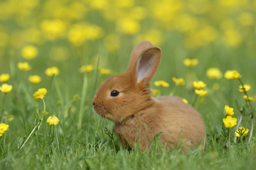

In [11]:
from fastdownload import download_url
dest = 'bunny.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


# # Use download_images to download the image, which handles potential download issues
# from fastai.vision.all import download_images
# dest = 'bunny.jpg'
# # Download the single image from the first URL in the urls list
# download_images(dest, urls=[urls[0]])

# im = Image.open(dest)
# im.to_thumb(256, 256)

In [ ]:
download_url(search_images('llama photos', max_images=1)[0], 'llama.jpg', show_progress=False)
Image.open('llama.jpg').to_thumb(256, 256)

In [ ]:
searches = 'bunny', 'llama'
path = Path('bunny_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
# remove any photos that do not download correctly
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
dls = ImageDataLoaders.from_path_func(path=path,
    fnames=get_image_files(path), valid_pct=0.2, seed=42,
    label_func=parent_label,
    item_tfms=[Resize(192, method='squish')])

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [ ]:
is_bunny,_,probs = learn.predict(PILImage.create('bunny.jpg'))
print(f'This is a : {is_bunny}.')
print(f"Probability it's a bunny: {probs[0]:.4f}")

is_bunny,_,probs = learn.predict(PILImage.create('llama.jpg'))
print(f'This is a : {is_bunny}.')
print(f"Probability it's a {is_bunny}: {max(probs):.4f}")

In [ ]:
learn.export('bunny-model.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: name 'ImageClassifierCleaner' is not defined

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)